In [1]:
# Download OMP
!wget -qO- https://github.com/OFAI/million-post-corpus/releases/download/v1.0.0/million_post_corpus.tar.bz2 | tar -xj --strip-components 1 "million_post_corpus/corpus.sqlite3"

In [2]:
!wget -qO dataset.csv "https://drive.google.com/uc?export=download&id=19tJyVyUo2IE8B8rJ8S9n8mJ4Cxsidz4c"

In [3]:
!nvidia-smi

Wed Jan 13 16:45:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install transformers==3.5.1 sentence-transformers==0.3.9

     |████████████████████████████████| 1.3MB 12.0MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 1.1MB 51.9MB/s 
     |████████████████████████████████| 2.9MB 48.9MB/s 
     |████████████████████████████████| 890kB 41.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101035 sha256=92851e8b48ba9f0c4f1334419e63a05dc4c71f84fc1b6dffd1a8ec33b5fb48b8
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=a2b1080a8dded406a05e160d4fdefc22c9e76f71a7d5c5c5fbfc45bb60f9e1aa
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [5]:
from pathlib import Path
import sqlite3
from prettytable import PrettyTable, from_db_cursor
import pandas as pd
from sentence_transformers import SentenceTransformer
from sentence_transformers import models as stm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
import sklearn.metrics
from sklearn.exceptions import NotFittedError, ConvergenceWarning
import numpy as np
from tqdm.notebook import tqdm, trange
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from timeit import default_timer as timer

In [20]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 100

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

warnings.simplefilter('ignore', category=ConvergenceWarning)

# Load embedding models

In [7]:
def BertCLSTransformer(model_name: str):
  # Standard BERT CLS token embeddings
  # This is similar to how the Forum 4.0 embeddings are currently generated
  word_embedding_model = stm.BERT(model_name)
  pooling_model = stm.Pooling(
      word_embedding_dimension=word_embedding_model.get_word_embedding_dimension(),
      pooling_mode_cls_token=True,
      pooling_mode_max_tokens=False,
      pooling_mode_mean_tokens=False,
      pooling_mode_mean_sqrt_len_tokens=False,
  )
  return SentenceTransformer(modules=[word_embedding_model, pooling_model])

## Forum 4.0 Embedding Implementation

In [15]:
# based on https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/extract_features.py
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Extract pre-computed feature vectors from a PyTorch BERT model."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import re
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

from transformers import BertTokenizer, BertModel

class InputExample(object):

    def __init__(self, unique_id, text_a, text_b):
        self.unique_id = unique_id
        self.text_a = text_a
        self.text_b = text_b


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, unique_id, tokens, input_ids, input_mask, input_type_ids):
        self.unique_id = unique_id
        self.tokens = tokens
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.input_type_ids = input_type_ids


class BertFeatureExtractor(object):

    def __init__(self, bert_model = "bert-base-german-cased", do_lower_case="False", max_seq_length=256,
                 batch_size=32, device = None,keep_cls=False, use_layers=4 , use_token=True):
        # parameter explanation
        # keep_cls is used to decide whether or not to keep CLS with all the tokens
        # use_layers is used to decide how many layers from the last layer to be used
        # use_token is used to decide whether to use the tokens or the CLS

        # number of layers cannot be greater than 13 (12 hidden +one output)
        if(use_layers > 13):
            use_layers=13


        if device:
            print("Configured device: " + device)
            self.device = torch.device(device)
        else:
            device = "cuda" if torch.cuda.is_available() else "cpu"
            print("Selected device: " + device)
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_gpu = torch.cuda.device_count()
        print(f"Device: {self.device} n_gpu: {self.n_gpu}")

        self.layer_weights = list(np.arange(1,use_layers+1))
        self.layer_indexes = [int(-x) for x in self.layer_weights]
        self.layer_weights.sort(reverse=True)
        self.keep_cls =keep_cls
        self.use_token= use_token

        # self.layers = "-1,-2,-3,-4"
        # self.layer_weights = [4, 3, 2, 1]
        # self.layer_indexes = [int(x) for x in self.layers.split(",")]

        self.bert_model = bert_model
        self.do_lower_case = do_lower_case
        self.max_seq_length = max_seq_length
        self.batch_size = batch_size

        self.tokenizer = BertTokenizer.from_pretrained(self.bert_model, do_lower_case=self.do_lower_case,
                                                       cache_dir="./model")

        self.model = BertModel.from_pretrained(self.bert_model, cache_dir="./model", output_hidden_states=True)

        self.model.to(self.device)
        self.model.eval()


    def convert_examples_to_features(self, examples, seq_length, tokenizer):
        """Loads a data file into a list of `InputFeature`s."""

        features = []
        for (ex_index, example) in enumerate(examples):
            tokens_a = tokenizer.tokenize(example.text_a)

            tokens_b = None
            if example.text_b:
                tokens_b = tokenizer.tokenize(example.text_b)

            if tokens_b:
                # Modifies `tokens_a` and `tokens_b` in place so that the total
                # length is less than the specified length.
                # Account for [CLS], [SEP], [SEP] with "- 3"
                self._truncate_seq_pair(tokens_a, tokens_b, seq_length - 3)
            else:
                # Account for [CLS] and [SEP] with "- 2"
                if len(tokens_a) > seq_length - 2:
                    tokens_a = tokens_a[0:(seq_length - 2)]

            # The convention in BERT is:
            # (a) For sequence pairs:
            #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
            #  type_ids:   0   0  0    0    0     0      0   0    1  1  1   1  1   1
            # (b) For single sequences:
            #  tokens:   [CLS] the dog is hairy . [SEP]
            #  type_ids:   0   0   0   0  0     0   0
            #
            # Where "type_ids" are used to indicate whether this is the first
            # sequence or the second sequence. The embedding vectors for `type=0` and
            # `type=1` were learned during pre-training and are added to the wordpiece
            # embedding vector (and position vector). This is not *strictly* necessary
            # since the [SEP] token unambigiously separates the sequences, but it makes
            # it easier for the model to learn the concept of sequences.
            #
            # For classification tasks, the first vector (corresponding to [CLS]) is
            # used as as the "sentence vector". Note that this only makes sense because
            # the entire model is fine-tuned.
            tokens = []
            input_type_ids = []
            tokens.append("[CLS]")
            input_type_ids.append(0)
            for token in tokens_a:
                tokens.append(token)
                input_type_ids.append(0)
            tokens.append("[SEP]")
            input_type_ids.append(0)

            if tokens_b:
                for token in tokens_b:
                    tokens.append(token)
                    input_type_ids.append(1)
                tokens.append("[SEP]")
                input_type_ids.append(1)

            input_ids = tokenizer.convert_tokens_to_ids(tokens)

            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1] * len(input_ids)

            # Zero-pad up to the sequence length.
            while len(input_ids) < seq_length:
                input_ids.append(0)
                input_mask.append(0)
                input_type_ids.append(0)

            assert len(input_ids) == seq_length
            assert len(input_mask) == seq_length
            assert len(input_type_ids) == seq_length

            features.append(
                InputFeatures(
                    unique_id=example.unique_id,
                    tokens=tokens,
                    input_ids=input_ids,
                    input_mask=input_mask,
                    input_type_ids=input_type_ids))

        return features


    def _truncate_seq_pair(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length."""

        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
            else:
                tokens_b.pop()


    def convert_sequences_to_examples(self, sequences):
        """Converts a list of strings to input examples (accepts ||| separated sequence pairs)."""
        examples = []
        unique_id = 0
        for line in sequences:
            line = line.strip()
            if not line:
                break
            text_a = None
            text_b = None
            m = re.match(r"^(.*) \|\|\| (.*)$", line)
            if m is None:
                text_a = line
            else:
                text_a = m.group(1)
                text_b = m.group(2)
            examples.append(InputExample(unique_id=unique_id, text_a=text_a, text_b=text_b))
            unique_id += 1
        return examples


    def encode(self, sequences, show_progress_bar=False):

        examples = self.convert_sequences_to_examples(sequences)

        features = self.convert_examples_to_features(
            examples=examples, seq_length=self.max_seq_length, tokenizer=self.tokenizer)

        unique_id_to_feature = {}
        for feature in features:
            unique_id_to_feature[feature.unique_id] = feature

        all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
        all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)

        eval_data = TensorDataset(all_input_ids, all_input_mask, all_example_index)
        eval_sampler = SequentialSampler(eval_data)
        eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=self.batch_size)

        be_result = []

        with torch.no_grad():
            for input_ids, input_mask, example_indices in tqdm(eval_dataloader, desc='Batches', disable=not show_progress_bar):
                input_ids = input_ids.to(self.device)
                input_mask = input_mask.to(self.device)

                model_output = self.model(input_ids, token_type_ids=None, attention_mask=input_mask)
                all_encoder_layers = model_output[2] # layer outputs

                for b, example_index in enumerate(example_indices):
                    feature = features[example_index.item()]
                    unique_id = int(feature.unique_id)

                    # todo:
                    # - pool all tokens instead of CLS
                    # - fine tune on mongodb dataset (NSP + MLM)
                    # - eval on downstream task (CV on OMP categories)
                    CLS_index = 0
                    all_layers = []
                    for (j, layer_index) in enumerate(self.layer_indexes):
                        layer_output = all_encoder_layers[int(layer_index)].detach().cpu().numpy()

                        if(self.use_token):
                            if(self.keep_cls):
                                layer_output = np.mean(layer_output[b, :],axis=0)
                            else:
                                layer_output = np.mean(layer_output[b, CLS_index+1:],axis=0)
                        else:
                            layer_output = layer_output[b,CLS_index]

                        # weighted sum of final j layers
                        all_layers.append(layer_output * self.layer_weights[j])
                    sequence_embedding = np.sum(all_layers, axis=0)

                    be_result.append(sequence_embedding.tolist())

        return np.array(be_result)

## Load models

In [9]:
emb_bert_ger = BertFeatureExtractor(bert_model='bert-base-german-cased', do_lower_case=False)
emb_bert_en = BertFeatureExtractor(bert_model='bert-base-uncased', do_lower_case=True)
# alternative: emb_bert_multi = BertCLSTransformer('bert-base-multilingual-cased')

emb_sbert_multi = SentenceTransformer('distiluse-base-multilingual-cased-v2')

Selected device: cuda
Device: cuda n_gpu: 1



Selected device: cuda
Device: cuda n_gpu: 1


100%|██████████| 504M/504M [00:31<00:00, 16.2MB/s]


# Prepare datasets

In [10]:
dss = {}

## OMP

In [11]:
conn = sqlite3.connect('corpus.sqlite3')
cur = conn.cursor()

In [12]:
cur.execute('SELECT Name FROM Categories')
print(from_db_cursor(cur))

+-------------------+
|        Name       |
+-------------------+
|   ArgumentsUsed   |
|   Discriminating  |
|   Inappropriate   |
|      OffTopic     |
|  PersonalStories  |
|  PossiblyFeedback |
| SentimentNegative |
|  SentimentNeutral |
| SentimentPositive |
+-------------------+


In [13]:
query = ' '.join([
    "SELECT",
    "  trim(coalesce(P.Headline, '') || ' ' || coalesce(P.Body, ''), ' ') text,"
    "  A.Value label",
    "FROM Annotations_consolidated A",
    "JOIN Posts P on A.ID_Post = P.ID_Post",
    "WHERE A.Category = ?"
])

omp_cat = "PersonalStories"  #@param {type: "string"}
cur.execute(query, (omp_cat,))
omp_texts, omp_labels = zip(*cur.fetchall())

dss['OMP'] = {
    'X': {
        'BERT': emb_bert_ger.encode(omp_texts, show_progress_bar=True),
        'SBERT': emb_sbert_multi.encode(omp_texts, show_progress_bar=True),
    },
    'y': np.array(omp_labels)
}

## Bug

In [14]:
bug_df = pd.read_csv('dataset.csv', index_col=0)

# 1 vs. rest binary classifier
bug_true_category = 'pbr'  # pbr is 1, rest (inq, irr) is 0
bug_df = bug_df[(bug_df['source'] == 'app_review') & (bug_df['lang'] == 'en') & ~bug_df['text'].isna()]

dss['bug'] = {
    'X': {
        'BERT': emb_bert_en.encode(bug_df['text'].to_list(), show_progress_bar=True),
        'SBERT': emb_sbert_multi.encode(bug_df['text'].to_list(), show_progress_bar=True),
    },
    'y': (bug_df['category'] == bug_true_category).astype(int).to_numpy(),
}

# Sampling strategies

In [16]:
rs = np.random.RandomState(0)

In [17]:
class Sampler:
  def __init__(self, X, y):
    self.X = X
    self.y = y
    self.is_train = np.full_like(y, False, dtype=bool)

  def sample_more(self, n: int = 25):
    idxs_of_remaining = self.choose(n, self.X[~self.is_train], self.y[~self.is_train])  # outputs n indices from the remaining samples (between 0 and n_remaining-1)
    idxs = np.arange(len(self.X))[~self.is_train][idxs_of_remaining]  # map to full dataset size (between 0 and len(X)-1)
    self.is_train[idxs] = True  # mark selected samples as training samples

    return (
        (self.X[self.is_train], self.y[self.is_train]),  # (X_train, y_train)
        (self.X[~self.is_train], self.y[~self.is_train]),  # (X_test, y_test)
    )
  
  def choose(self, n, X, y):
    raise NotImplementedError
  

class RandomSampler(Sampler):
  def choose(self, n, X, y):
    return rs.choice(len(X), size=n, replace=False)


class UncertaintySampler(Sampler):
  def __init__(self, X, y, clf):
    super().__init__(X, y)
    self.clf = clf
  
  def choose(self, n, X, y):
    try:
      confidences = self.clf.predict_proba(X)[:, 0]
      return np.argsort(np.abs(0.5 - confidences))[:n]
    except NotFittedError:
      return rs.choice(len(X), size=n, replace=False)

In [18]:
n_new_samples_per_training = 10  #@param {type: "number"}
n_trainings = 50  #@param {type: "number"}
n_rounds = 25  #@param {type: "number"}


# Evaluation

In [19]:
results = []

with tqdm(total=8) as experiment_pbar:
  for ds_name, ds in dss.items():
    for model_name, X in ds['X'].items():
      for strat in ['rnd', 'unc']:

        experiment_pbar.set_postfix({'dataset': ds_name, 'model': model_name, 'strategy': strat})

        round = 0
        with tqdm(total=n_rounds, leave=False) as round_pbar:
          while round < n_rounds:
            clf = LogisticRegression(
              random_state=42,
              class_weight='balanced',
              solver='saga',
              penalty='elasticnet',
              tol=0.0001,
              max_iter=100,
              C=1.0,
              l1_ratio=0.5
            )

            if strat == 'rnd':
              sampler = RandomSampler(X, ds['y'])
            else:
              sampler = UncertaintySampler(X, ds['y'], clf)

            try:
              round_results = []
              for _ in range(n_trainings):
                (X_train, y_train), (X_test, y_test) = sampler.sample_more(n_new_samples_per_training)
                
                # training
                train_start = timer()
                clf.fit(X_train, y_train)
                train_end = timer()

                # testing
                test_start = timer()
                y_pred_proba = clf.predict_proba(X_test)[:, 1]
                test_end = timer()

                round_results.append({
                    'dataset': ds_name,
                    'model': model_name,
                    'strategy': strat,
                    'round': round,
                    'train_time': train_end - train_start,
                    'test_time': test_end - test_start,
                    'n_train': len(y_train),
                    'n_test': len(y_test),
                    'n_train_true': y_train.sum(),
                    'y_test_true': y_test,
                    'y_test_pred_proba': y_pred_proba,
                })
              
              results.extend(round_results)
              round_pbar.update(1)
              round += 1
            except ValueError:
              pass
        experiment_pbar.update(1)

# Analysis

In [21]:
for result in results:
  y_true = result['y_test_true']
  y_pred_proba = result['y_test_pred_proba']
  y_pred = (y_pred_proba >= 0.5).astype(np.int)
  result['scores'] = {
      'acc': sklearn.metrics.accuracy_score(y_true, y_pred),
      'balanced_acc': sklearn.metrics.balanced_accuracy_score(y_true, y_pred),
      'f1': sklearn.metrics.f1_score(y_true, y_pred),
      'precision': sklearn.metrics.precision_score(y_true, y_pred, zero_division='warn') if y_pred.sum() > 0 else None,  # TODO: How to handle?
      'recall': sklearn.metrics.recall_score(y_true, y_pred),
      'roc_auc': sklearn.metrics.roc_auc_score(y_true, y_pred_proba),
  }

In [22]:
eval_df = pd.json_normalize(results)
eval_df['y_test_pred'] = eval_df['y_test_pred_proba'].map(lambda proba: (proba >= 0.5).astype(np.int))
eval_df['n_test_true'] = eval_df['y_test_true'].map(np.sum)
eval_df = eval_df.drop(columns=['y_test_true', 'y_test_pred', 'y_test_pred_proba'])
eval_df.to_csv('results.csv')
eval_df

,dataset,model,strategy,round,train_time,test_time,n_train,n_test,n_train_true,scores.acc,scores.balanced_acc,scores.f1,scores.precision,scores.recall,scores.roc_auc,n_test_true
0,OMP,BERT,rnd,0,0.021611,0.008877,10,9326,2,0.834334,0.653878,0.442037,0.534031,0.377079,0.837358,1623
1,OMP,BERT,rnd,0,0.040402,0.008725,20,9316,5,0.795942,0.743936,0.530965,0.442252,0.664198,0.832950,1620
2,OMP,BERT,rnd,0,0.059594,0.008796,30,9306,5,0.851601,0.717970,0.546172,0.583978,0.512963,0.849858,1620
3,OMP,BERT,rnd,0,0.077583,0.014550,40,9296,9,0.863382,0.769515,0.614216,0.603222,0.625619,0.885246,1616
4,OMP,BERT,rnd,0,0.092549,0.009174,50,9286,10,0.873573,0.800292,0.654299,0.623807,0.687926,0.904907,1615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,bug,SBERT,unc,24,0.151647,0.003437,460,5932,160,0.923972,0.916325,0.836416,0.779054,0.902897,0.966359,1277
9996,bug,SBERT,unc,24,0.150894,0.003614,470,5922,165,0.924856,0.917884,0.838123,0.779959,0.905660,0.967413,1272
9997,bug,SBERT,unc,24,0.158656,0.003577,480,5912,171,0.924222,0.916733,0.836257,0.778231,0.903633,0.967670,1266
9998,bug,SBERT,unc,24,0.167050,0.003478,490,5902,175,0.925618,0.918947,0.839135,0.780504,0.907290,0.967902,1262


In [23]:
rename_title = {'OMP' : 'PersonalStories', 'bug' : 'Bug Report'}

def ds_plot(plot_fn, df=None, xlim=None, ylim=None, xlabel=None, ylabel=None, show_title=False):
    global eval_df
    if df is None:
        df = eval_df

    ds_names = df['dataset'].unique()
    fig, axs = plt.subplots(1, len(dss), sharey=False)
    for axss in axs:
        if ylim is not None:
            axss.set_ylim(ylim)
        if xlim is not None:
            axss.set_xlim(xlim)
            
    for ax, ds_name in zip(axs, dss.keys()):
        if show_title:
            ax.set_title(rename_title[ds_name])
        plt.sca(ax)
        p = plot_fn(df[df['dataset'] == ds_name])
        p.set(xlabel=xlabel, ylabel=ylabel)
        plt.grid(True)
    return fig

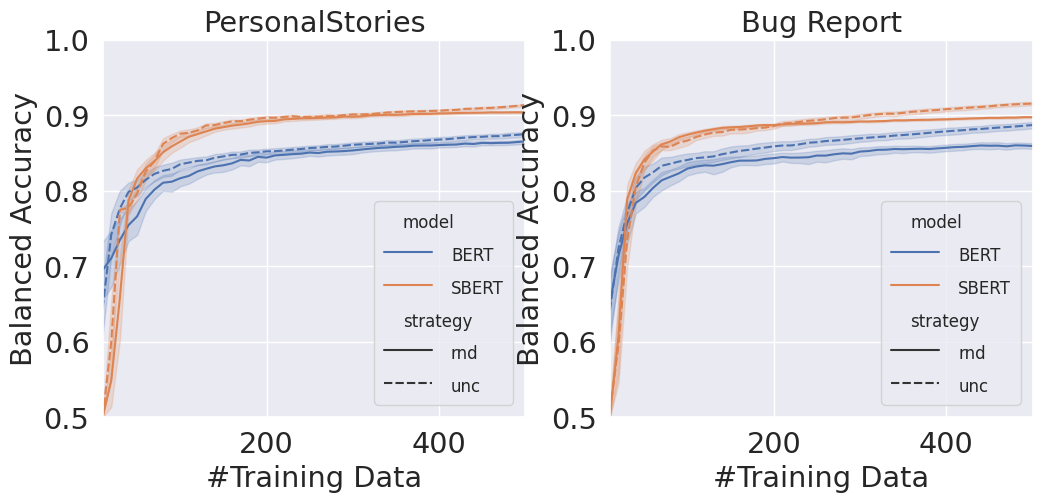

In [24]:
fig = ds_plot(lambda ds_df: sns.lineplot(data=ds_df, x='n_train', y='scores.balanced_acc', hue='model', style='strategy'), xlim=(10, 500.0), ylim=(0.5, 1.0), ylabel='Balanced Accuracy', xlabel='#Training Data', show_title=True)
plt.savefig('plt_ba.pdf', bbox_inches = 'tight', pad_inches = 0)

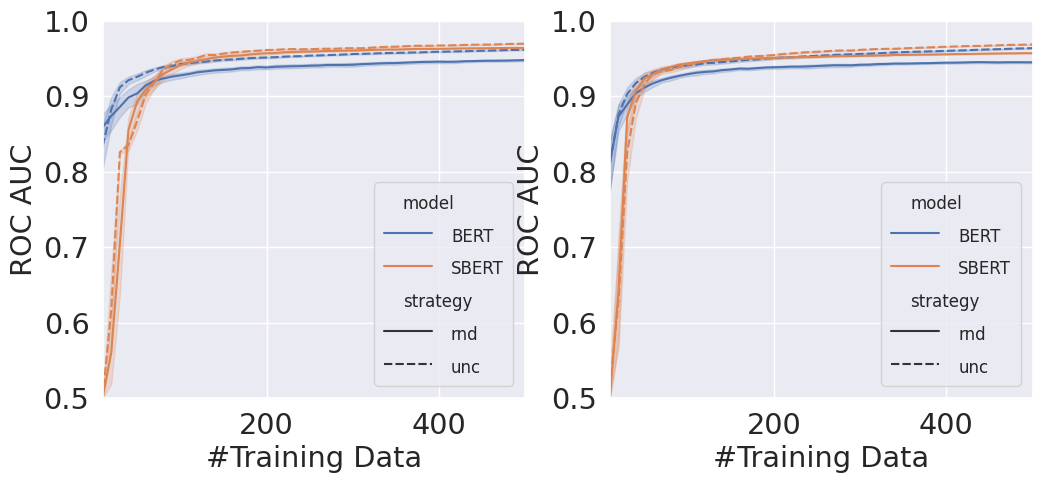

In [25]:
ds_plot(lambda ds_df: sns.lineplot(data=ds_df, x='n_train', y='scores.roc_auc', hue='model', style='strategy'), xlim=(10, 500.0), ylim=(0.5, 1.0), ylabel='ROC AUC', xlabel='#Training Data')
plt.savefig('plt_ar.pdf', bbox_inches = 'tight', pad_inches = 0)

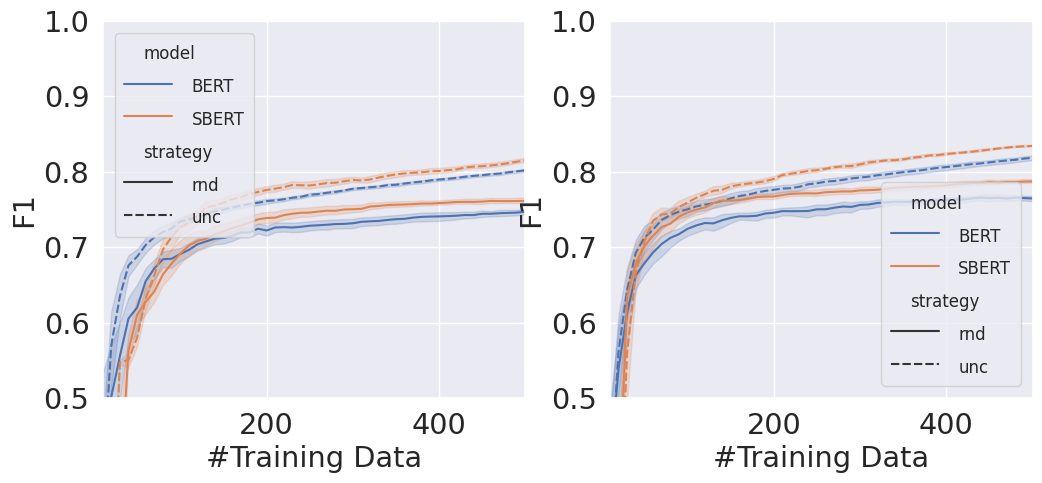

In [26]:
ds_plot(lambda ds_df: sns.lineplot(data=ds_df, x='n_train', y='scores.f1', hue='model', style='strategy'), xlim=(10, 500.0), ylim=(0.5, 1.0), ylabel='F1', xlabel='#Training Data')
plt.savefig('plt_f1.pdf', bbox_inches = 'tight', pad_inches = 0)

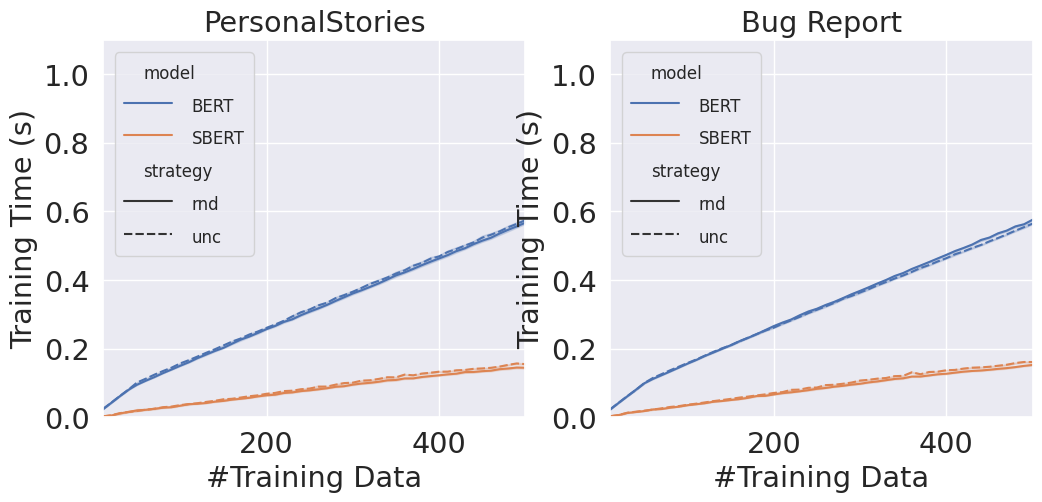

In [27]:
ds_plot(lambda ds_df: sns.lineplot(data=ds_df, x='n_train', y='train_time', hue='model', style='strategy'), xlim=(10, 500.0), ylim=(0, 1.1), ylabel='Training Time (s)', xlabel='#Training Data', show_title=True)
plt.savefig('plt_time_train.pdf', bbox_inches = 'tight', pad_inches = 0)

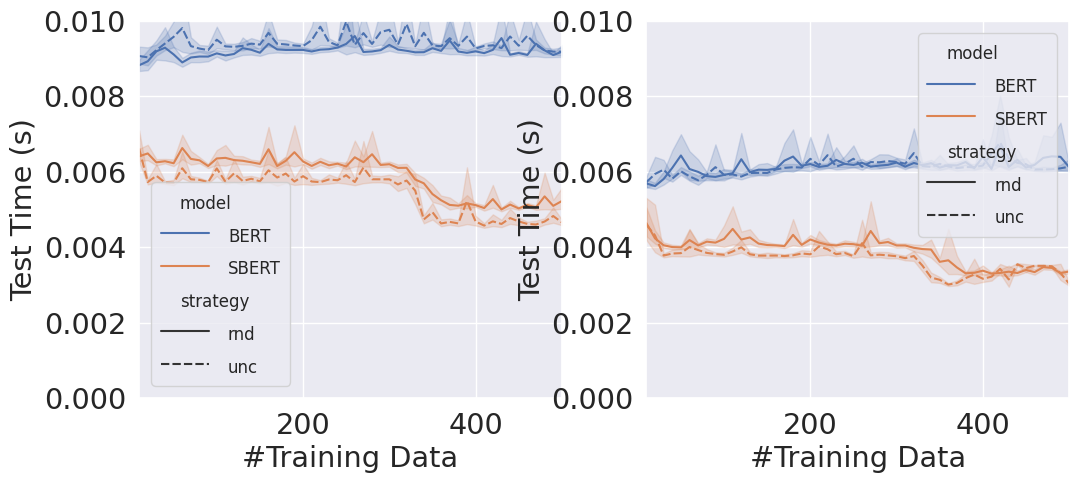

In [28]:
ds_plot(lambda ds_df: sns.lineplot(data=ds_df, x='n_train', y='test_time', hue='model', style='strategy'), xlim=(10, 500.0), ylim=(0, 0.01), ylabel='Test Time (s)', xlabel='#Training Data')
plt.savefig('plt_time_test.pdf', bbox_inches = 'tight', pad_inches = 0)